In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
import scipy.optimize as optimize
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)  # inches

In [2]:
#%% 用户设置参数，可编辑
file_path=r'.\IMG_1548.DNG'

black_level=None #黑电平值，需根据设备不同更改，iPhone12的值为528
white_level=None #白电平值，需根据设备不同更改，iPhone12的值为4095

b'RGBG'
[[0 1]
 [3 2]]


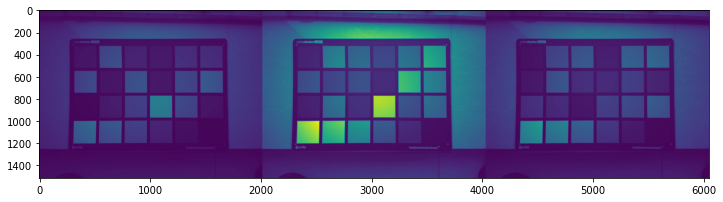

In [3]:
raw = rawpy.imread(file_path)
print(raw.color_desc)
print(raw.raw_pattern)  # RGBG按照pattern格式在左上角排列
img=raw.raw_image
img_r=img[0::2,0::2].astype('float32')
img_gr=img[0::2,1::2].astype('float32')
img_gb=img[1::2,0::2].astype('float32')
img_b=img[1::2,1::2].astype('float32')
img_g=(img_gr+img_gb)/2
plt.imshow(np.hstack([img_r, img_g, img_b]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


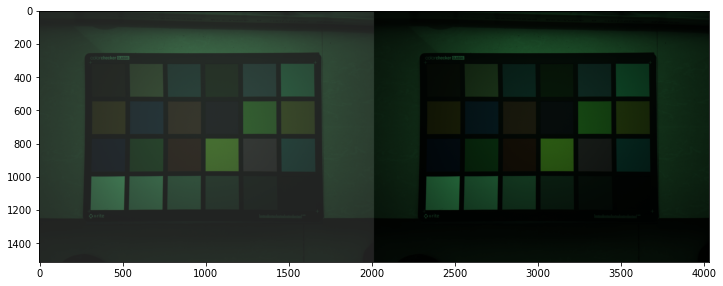

In [4]:
#OB
if black_level is None: #读取Raw图MetaData中黑电平值
    black_level=raw.black_level_per_channel
if white_level is None: #读取Raw图MetaData中白电平值
    white_level=raw.white_level

img_0=(np.dstack((img_r,img_g,img_b)))/(white_level) #img_0:未OB的图像
img_r=(img_r-black_level[0])/(white_level-black_level[0])
img_gr=(img_gr-black_level[1])/(white_level-black_level[1])
img_gb=(img_gb-black_level[2])/(white_level-black_level[2])
img_b=(img_b-black_level[3])/(white_level-black_level[3])
img_g=(img_gr+img_gb)/2
img=np.dstack((img_r,img_g,img_b))
img_1=img #img_0:OB后的图像
plt.imshow(np.hstack([img_0,img_1]))

In [5]:
def im2vector(img): #将图片转换为向量形式
    size=img.shape
    rgb=np.reshape(img,(size[0]*size[1],3))
    func_reverse=lambda rgb : np.reshape(rgb,(size[0],size[1],size[2]))
    return rgb, func_reverse

M_xyz2rgb=np.array([[3.24096994,-1.53738318,-0.49861076],
                    [-0.96924364,1.8759675,0.04155506],
                    [0.05563008,-0.20397695,1.05697151]])
M_rgb2xyz=np.array([[0.4123908 , 0.35758434, 0.18048079],
                    [0.21263901, 0.71516868, 0.07219231],
                    [0.01933082, 0.11919478, 0.95053216]])

def gamma(x,colorspace='sRGB'): #Gamma变换
    y=np. zeros (x.shape)
    y[x>1]=1
    if colorspace in ('sRGB', 'srgh'):
        y[(x>=0)&(x<=0.0031308)]=(323/25*x[(x>=0)&(x<=0.0031308)])
        y[(x<=1)&(x>0.0031308)]=(1.055*abs(x[(x<=1)&(x>0.0031308)])**(1/2.4)-0.055)
    elif colorspace in ('TP', 'my'):  
        y[(x>=0)&(x<=1)]=(1.42*(1-(0.42/(x[(x>=0)&(x<=1)]+0.42))))
    elif (type(colorspace)==float)|(type(colorspace)==int):
        beta=colorspace
        y[(x>=0)&(x<=1)]=((1+beta)*(1-(beta/(x[(x>=0)&(x<=1)]+beta))))
    return y

def gamma_reverse(x,colorspace='sRGB'): #逆Gamma变换
    y=np.zeros(x.shape)
    y[x>1]=1
    if colorspace in ('sRGB', 'srgb'):
        y[(x>=0)&(x<=0.04045)]=x[(x>=0)&(x<=0.04045)]/12.92
        y[(x>0.04045)&(x<=1)]=((x[(x>0.04045)&(x<=1)]+0.055)/1.055)**2.4
    elif colorspace in ('TP','my'):
        y[(x>=0)&(x<=1)]=0.42/(1-(x[(x>=0)&(x<=1)]/1.42))-0.42         
    return y

In [6]:
def impoly(img,poly_position=None): #四边形框选图像ROI
    """
    弹出图片，按顺序点选色卡左上↖、右上↗、右下↘、左下↙4个定位点 
    """
    if poly_position is None:
        fig=plt.figure(figsize=[12.,7.5],tight_layout=True)
        plt.imshow(img)
        pos=plt.ginput(n=4, timeout=60)
    else:
        pos=poly_position
    (n,m)=np.meshgrid(np.arange(0.5,6.5)/6,np.arange(0.5,4.5)/4)
    n=n.flatten()
    m=m.flatten()
    x_center=(1-m)*((1-n)*pos[0][0]+n*pos[1][0])+m*(n*pos[2][0]+(1-n)*pos[3][0])
    y_center=(1-m)*((1-n)*pos[0][1]+n*pos[1][1])+m*(n*pos[2][1]+(1-n)*pos[3][1])
    r_sample=np.floor(min([abs(pos[1][0]-pos[0][0])/6,
                           abs(pos[2][0]-pos[3][0])/6,
                           abs(pos[1][1]-pos[2][1])/4,
                           abs(pos[0][1]-pos[3][1])/4]))*0.2
    if poly_position is None:
        plt.plot(pos[0][0],pos[0][1],'r+')
        plt.plot(pos[1][0],pos[1][1],'r+')
        plt.plot(pos[2][0],pos[2][1],'r+')
        plt.plot(pos[3][0],pos[3][1],'r+')
        plt.plot(x_center,y_center,'yo')
        plt.plot(x_center-r_sample,y_center-r_sample,'y+')
        plt.plot(x_center+r_sample,y_center-r_sample,'y+')
        plt.plot(x_center-r_sample,y_center+r_sample,'y+')
        plt.plot(x_center+r_sample,y_center+r_sample,'y+')
        plt.savefig('tmp_ploy.png')
        poly_position=pos
    else:
        pass
    rgb_mean=np.zeros((24,3)) # 24方块3通道的均值
    rgb_std=np.zeros((24,3))  # 24方块3通道的标准差
    blocks = []
    for block_idx in range(24):
        block=img[int(y_center[block_idx]-r_sample):int(y_center[block_idx]+r_sample),
                  int(x_center[block_idx]-r_sample):int(x_center[block_idx]+r_sample),:]
        blocks.append(block)
        rgb_vector,_=im2vector(block)
        rgb_mean[block_idx,:]=rgb_vector.mean(axis=0)  
        rgb_std[block_idx,:]=rgb_vector.std(axis=0)
    return rgb_mean,rgb_std,poly_position,blocks

In [7]:
%matplotlib auto
rgb_mean,rgb_std,poly_position,blocks=impoly(img)
print(poly_position)
%matplotlib inline

Using matplotlib backend: <object object at 0x000002125FE25690>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[(344.5214793605772, 332.0961053888161), (1643.1704807789183, 332.0961055906189), (1640.1362541403191, 1145.268844725484), (314.17921308842716, 1187.7480176653619)]


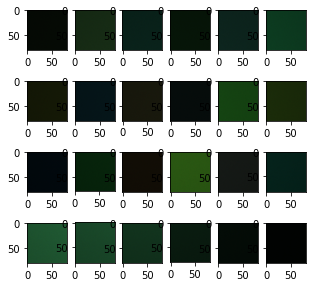

In [8]:
fig = plt.figure(figsize=(5, 5))
for i in range(24):
    ax = fig.add_subplot(4, 6, i + 1)
    ax.imshow(blocks[i])
plt.show()

In [9]:
def rgb2lab(img,whitepoint='D65'): #rgb转lab
    if (img.ndim==3):
        if (img.shape[2]==3):
            (rgb,func_reverse)=im2vector(img)
    elif (img.ndim==2):
        if (img.shape[1]==3):
            rgb=img
            func_reverse=lambda x : x
        elif (img.shape[0]>80)&(img.shape[1]>80):
            img=np.dstack((img,img,img))
            (rgb,Func_reverse)=im2vector(img)
    rgb=rgb.transpose()
    rgb=gamma_reverse(rgb,colorspace='sRGB')
    xyz=M_rgb2xyz@rgb
    xyz=xyz.transpose()
    f=lambda t : (t>((6/29)**3))*(t**(1/3))+\
        (t<=(6/29)**3)*(29*29/6/6/3*t+4/29)
    if whitepoint=='D65':
        Xn=95.047/100
        Yn=100/100
        Zn=108.883/100
    L=116*f(xyz[:,1]/Yn)-16
    a=500*(f(xyz[:,0]/Xn)-f(xyz[:,1]/Yn))
    b=200*(f(xyz[:,1]/Yn)-f(xyz[:,2]/Zn))
    Lab=np.vstack((L,a,b)).transpose()
    img_out=func_reverse(Lab)
    return img_out

def lab2rgb(img,whitepoint='D65'): #lab转rgb
    if (img.ndim==3):
        if (img.shape[2]==3):
            (lab,func_reverse)=im2vector(img)
    elif (img.ndim==2):
        if (img.shape[1]==3):
            lab=img
            func_reverse=lambda x : x
        elif (img.shape[0]>80)&(img.shape[1]>80):
            img=np.dstack((img,img,img))
            (lab,Func_reverse)=im2vector(img)
    lab=lab.transpose()
    if whitepoint=='D65':
        Xn=95.047/100
        Yn=100/100
        Zn=108.883/100
    f_reverse=lambda t : (t>(6/29))*(t**3)+\
        (t<=(6/29))*(3*((6/29)**2)*(t-4/29))
    xyz=np.vstack((Xn*f_reverse((lab[0,:]+16)/116+lab[1,:]/500),
                   Yn*f_reverse((lab[0,:]+16)/116),
                   Zn*f_reverse((lab[0,:]+16)/116-lab[2,:]/200) ))
    rgb=M_xyz2rgb@xyz
    rgb=rgb.transpose()
    rgb=gamma(rgb,colorspace='sRGB')
    rgb_out=func_reverse(rgb)
    return rgb_out

lab_ideal=np.array( # X-Rite官网提供的LAB色彩真值
    [[37.986,13.555,14.059],
      [65.711,18.13,17.81],
      [49.927,-4.88,-21.925],
      [43.139,-13.095,21.905],
      [55.112,8.844,-25.399],
      [70.719,-33.397,-0.199],
      [62.661,36.067,57.096],
      [40.02,10.41,-45.964],
      [51.124,48.239,16.248],
      [30.325,22.976,-21.587],
      [72.532,-23.709,57.255],
      [71.941,19.363,67.857],
      [28.778,14.179,-50.297],
      [55.261,-38.342,31.37],
      [42.101,53.378,28.19],
      [81.733,4.039,79.819],
      [51.935,49.986,-14.574],
      [51.038,-28.631,-28.638],
      [96.539,-0.425,1.186],
      [81.257,-0.638,-0.335],
      [66.766,-0.734,-0.504],
      [50.867,-0.153,-0.27],
      [35.656,-0.421,-1.231],
      [20.461,-0.079,-0.973]],dtype='float32')

rgb_ideal=lab2rgb(lab_ideal)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(24, 3)


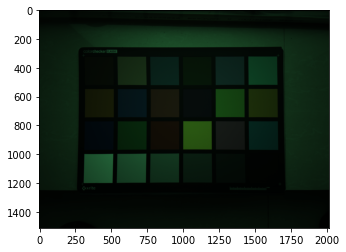

In [10]:
print(rgb_ideal.shape)
plt.imshow(img)

In [11]:
def awb(img, awb_para):  
    if (img.shape[1]==3)&(img.ndim==2):
        rgb=img
        func_reverse=lambda x : x    
    elif (img.shape[2]==3)&(img.ndim==3):
        (rgb,func_reverse)=im2vector(img)   
    rgb[:,0]=rgb[:,0]*awb_para[0]    
    rgb[:,1]=rgb[:,1]*awb_para[1]    
    rgb[:,2]=rgb[:,2]*awb_para[2]    
    img=func_reverse(rgb)    
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AE补偿: 1.9782616956024712


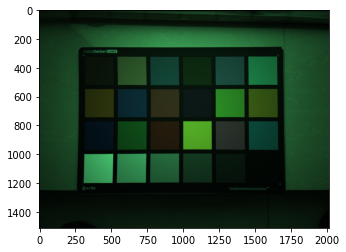

In [12]:
func_ae=lambda ae_comp : np.prod(gamma(ae_comp*rgb_mean[20:24,1]))/np.prod(rgb_ideal[20:24,1])-1
ae_res=optimize.root_scalar(func_ae, bracket=[0, 100], method='brentq')
ae_comp=ae_res.root
print('AE补偿:',ae_comp)
img=ae_comp*img
rgb_mean=ae_comp*rgb_mean
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AWB Gain = : [2.8913879294805125, 1, 1.7108947331457922]


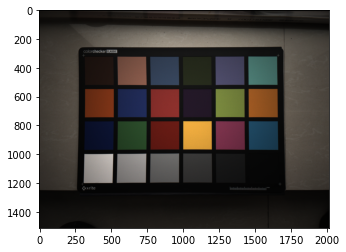

In [13]:
# 第22块的R=G=B，[G/R,1,G/B]
awb_para=[rgb_mean[22,1]/rgb_mean[22,0],1,rgb_mean[22,1]/rgb_mean[22,2]]
print('AWB Gain = :',awb_para)
img=awb(img,awb_para)
rgb_mean=awb(rgb_mean,awb_para)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


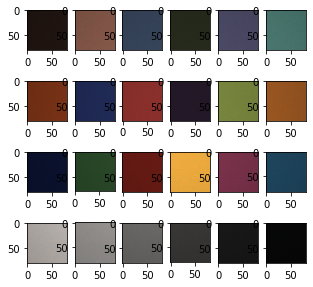

In [14]:
fig = plt.figure(figsize=(5, 5))
for i in range(24):
    ax = fig.add_subplot(4, 6, i + 1)
    blocks[i] = ae_comp * blocks[i]
    blocks[i] = awb(blocks[i],awb_para)
    ax.imshow(blocks[i])
plt.show()

In [15]:
def ccm(img, ccm):
    if (img.shape[1]==3)&(img.ndim==2):
        rgb=img
        func_reverse=lambda x : x    
    elif (img.shape[2]==3)&(img.ndim==3):
        (rgb,func_reverse)=im2vector(img)    
    rgb=rgb.transpose()
    rgb=ccm@rgb
    rgb=rgb.transpose()    
    img_out=func_reverse(rgb)    
    return img_out

In [16]:
img_2 = img
x2ccm=lambda x : np.array([[1-x[0]-x[1],x[0],x[1]],
                            [x[2],1-x[2]-x[3],x[3]],
                            [x[4],x[5],1-x[4]-x[5]]])

f_lab=lambda x : rgb2lab(gamma(ccm(rgb_mean,x2ccm(x)),colorspace='sRGB'))
f_error=lambda x : f_lab(x)-lab_ideal
f_DeltaE=lambda x : np.sqrt((f_error(x)**2).sum(axis=1,keepdims=True)).mean()
x0=np.array([0,0,0,0,0,0])
print('初始值:',f_DeltaE(x0))
func=lambda x : print('x = ',f_DeltaE(x))
result=optimize.minimize(f_DeltaE,x0,method='Powell',callback=func)
print(result)

初始值: 18.040498216053532
x =  9.38722142104304
x =  7.546591797245362
x =  6.1218425671549666
x =  5.69027875156434
x =  5.587907785653446
x =  5.394903819389026
x =  5.375753543709069
x =  5.353771255702976
x =  5.351646553413928
x =  5.349827934530478
   direc: array([[ 0.07383621, -0.04556749,  0.02063914,  0.01131399,  0.02971618,
        -0.07976604],
       [-0.09461778,  0.01778992,  0.01182879, -0.00133662,  0.012657  ,
        -0.02151657],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [-0.0176477 ,  0.01199448,  0.00348496,  0.0056809 ,  0.00391704,
        -0.00984294]])
     fun: 5.349827934530478
 message: 'Optimization terminated successfully.'
    nfev: 807
     nit: 10
  status: 0
 success: True
       x: array([-0.28117975, -0.3

In [17]:
img_3=ccm(img,x2ccm(result.x))
img_4=gamma(img_3)
img = img_4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


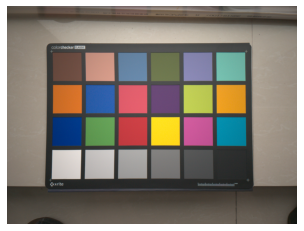

In [18]:
titles = ['RAW', 'BLC', 'AWB', 'CCM', 'GAMMA']
plt.axis('off')
for i in range(5):
    plt.imshow(eval('img_'+str(i)))
    plt.savefig('./output/'+titles[i], dpi=200)